In [2]:
# the default directory is the "notebooks" folder; set it one level up.
setwd("..")

In [3]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [4]:
library(readr)
library(dplyr)
library(tidyr)
library(purrr)
library(tibble)
library(ggplot2)
library(ggthemes)
library(ggpubr)
library(ComplexUpset)

## Functions

In [ ]:
read_gather <- function(path){
  gather <- read_csv(path, col_types = "ddddddddcccddddcccdc")
}

In [57]:
upset_overlap_groups <- function (listInput, sort = TRUE) {
  # listInput could look like this:
  # $one
  # [1] "a" "b" "c" "e" "g" "h" "k" "l" "m"
  # $two
  # [1] "a" "b" "d" "e" "j"
  # $three
  # [1] "a" "e" "f" "g" "h" "i" "j" "l" "m"
  listInputmat    <- UpSetR::fromList(listInput) == 1
  #     one   two three
  # a  TRUE  TRUE  TRUE
  # b  TRUE  TRUE FALSE
  #...
  # condensing matrix to unique combinations elements
  listInputunique <- unique(listInputmat)
  grouplist <- list()
  # going through all unique combinations and collect elements for each in a list
  for (i in 1:nrow(listInputunique)) {
    currentRow <- listInputunique[i,]
    myelements <- which(apply(listInputmat,1,function(x) all(x == currentRow)))
    attr(myelements, "groups") <- currentRow
    grouplist[[paste(colnames(listInputunique)[currentRow], collapse = "_")]] <- myelements
    myelements
    # attr(,"groups")
    #   one   two three 
    # FALSE FALSE  TRUE 
    #  f  i 
    # 12 13 
  }
  if (sort) {
    grouplist <- grouplist[order(sapply(grouplist, function(x) length(x)), decreasing = TRUE)]
  }
  attr(grouplist, "elements") <- unique(unlist(listInput))
  return(grouplist)
  # save element list to facilitate access using an index in case rownames are not named
}

## Read in `sourmash taxonomy` results

In [6]:
sourmash_taxonomy <- Sys.glob("outputs/sourmash_taxonomy/*k31*csv") %>%
  map_dfr(read_gather) %>% # read in files
  separate(lineage, into = c("kingdom", "phylum", "class", "order", "family", "genus", "species", "strain"),
           sep = ";", remove = F, fill = "right") %>% # separate lineage column into commensurate parts
  mutate(database = basename(filename),
         database = gsub("genbank-2022.03-", "", database),
         database = gsub("-k31.zip", "", database))

## Sample composition overview

#### How many total genomes (strains) were detected in each metagenome?

In [7]:
sourmash_taxonomy %>%
  group_by(query_name) %>%
  tally()

query_name,n
<chr>,<int>
SRR19888423,796
SRR19888427,827
SRR19888432,970
SRR19888434,1034
SRR19888438,773
SRR19888440,950


#### How many total species were detected in each metagenome?

In [8]:
sourmash_taxonomy %>%
  select(lineage, query_name) %>%
  distinct() %>%
  group_by(query_name) %>%
  tally()

query_name,n
<chr>,<int>
SRR19888423,652
SRR19888427,634
SRR19888432,833
SRR19888434,853
SRR19888438,626
SRR19888440,736


#### How many total genomes (strains) were detected among the metagenomes for each of the five lineages bacteria, archaea, viral, protozoa, fungi?

In [9]:
sourmash_taxonomy %>%
  group_by(database, query_name) %>%
  tally()

database,query_name,n
<chr>,<chr>,<int>
archaea,SRR19888432,2
archaea,SRR19888434,1
archaea,SRR19888440,2
bacteria,SRR19888423,787
bacteria,SRR19888427,810
bacteria,SRR19888432,958
bacteria,SRR19888434,1016
bacteria,SRR19888438,761
bacteria,SRR19888440,927


**How many distinct lineages were observed across all samples?**

In [11]:
sourmash_taxonomy %>%
  select(lineage) %>%
  distinct() %>%
  nrow()

[1] 1725

## plot something

In [12]:
bacteria_plot <- ggplot(sourmash_taxonomy %>% filter(database == "bacteria"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 20")

fungi_plot <- ggplot(sourmash_taxonomy %>% filter(database == "fungi"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Set1")

viral_plot <- ggplot(sourmash_taxonomy %>% filter(database == "viral"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Set2")

protozoa_plot <- ggplot(sourmash_taxonomy %>% filter(database == "protozoa"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Dark2")

archaea_plot <- ggplot(sourmash_taxonomy %>% filter(database == "archaea"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 10")

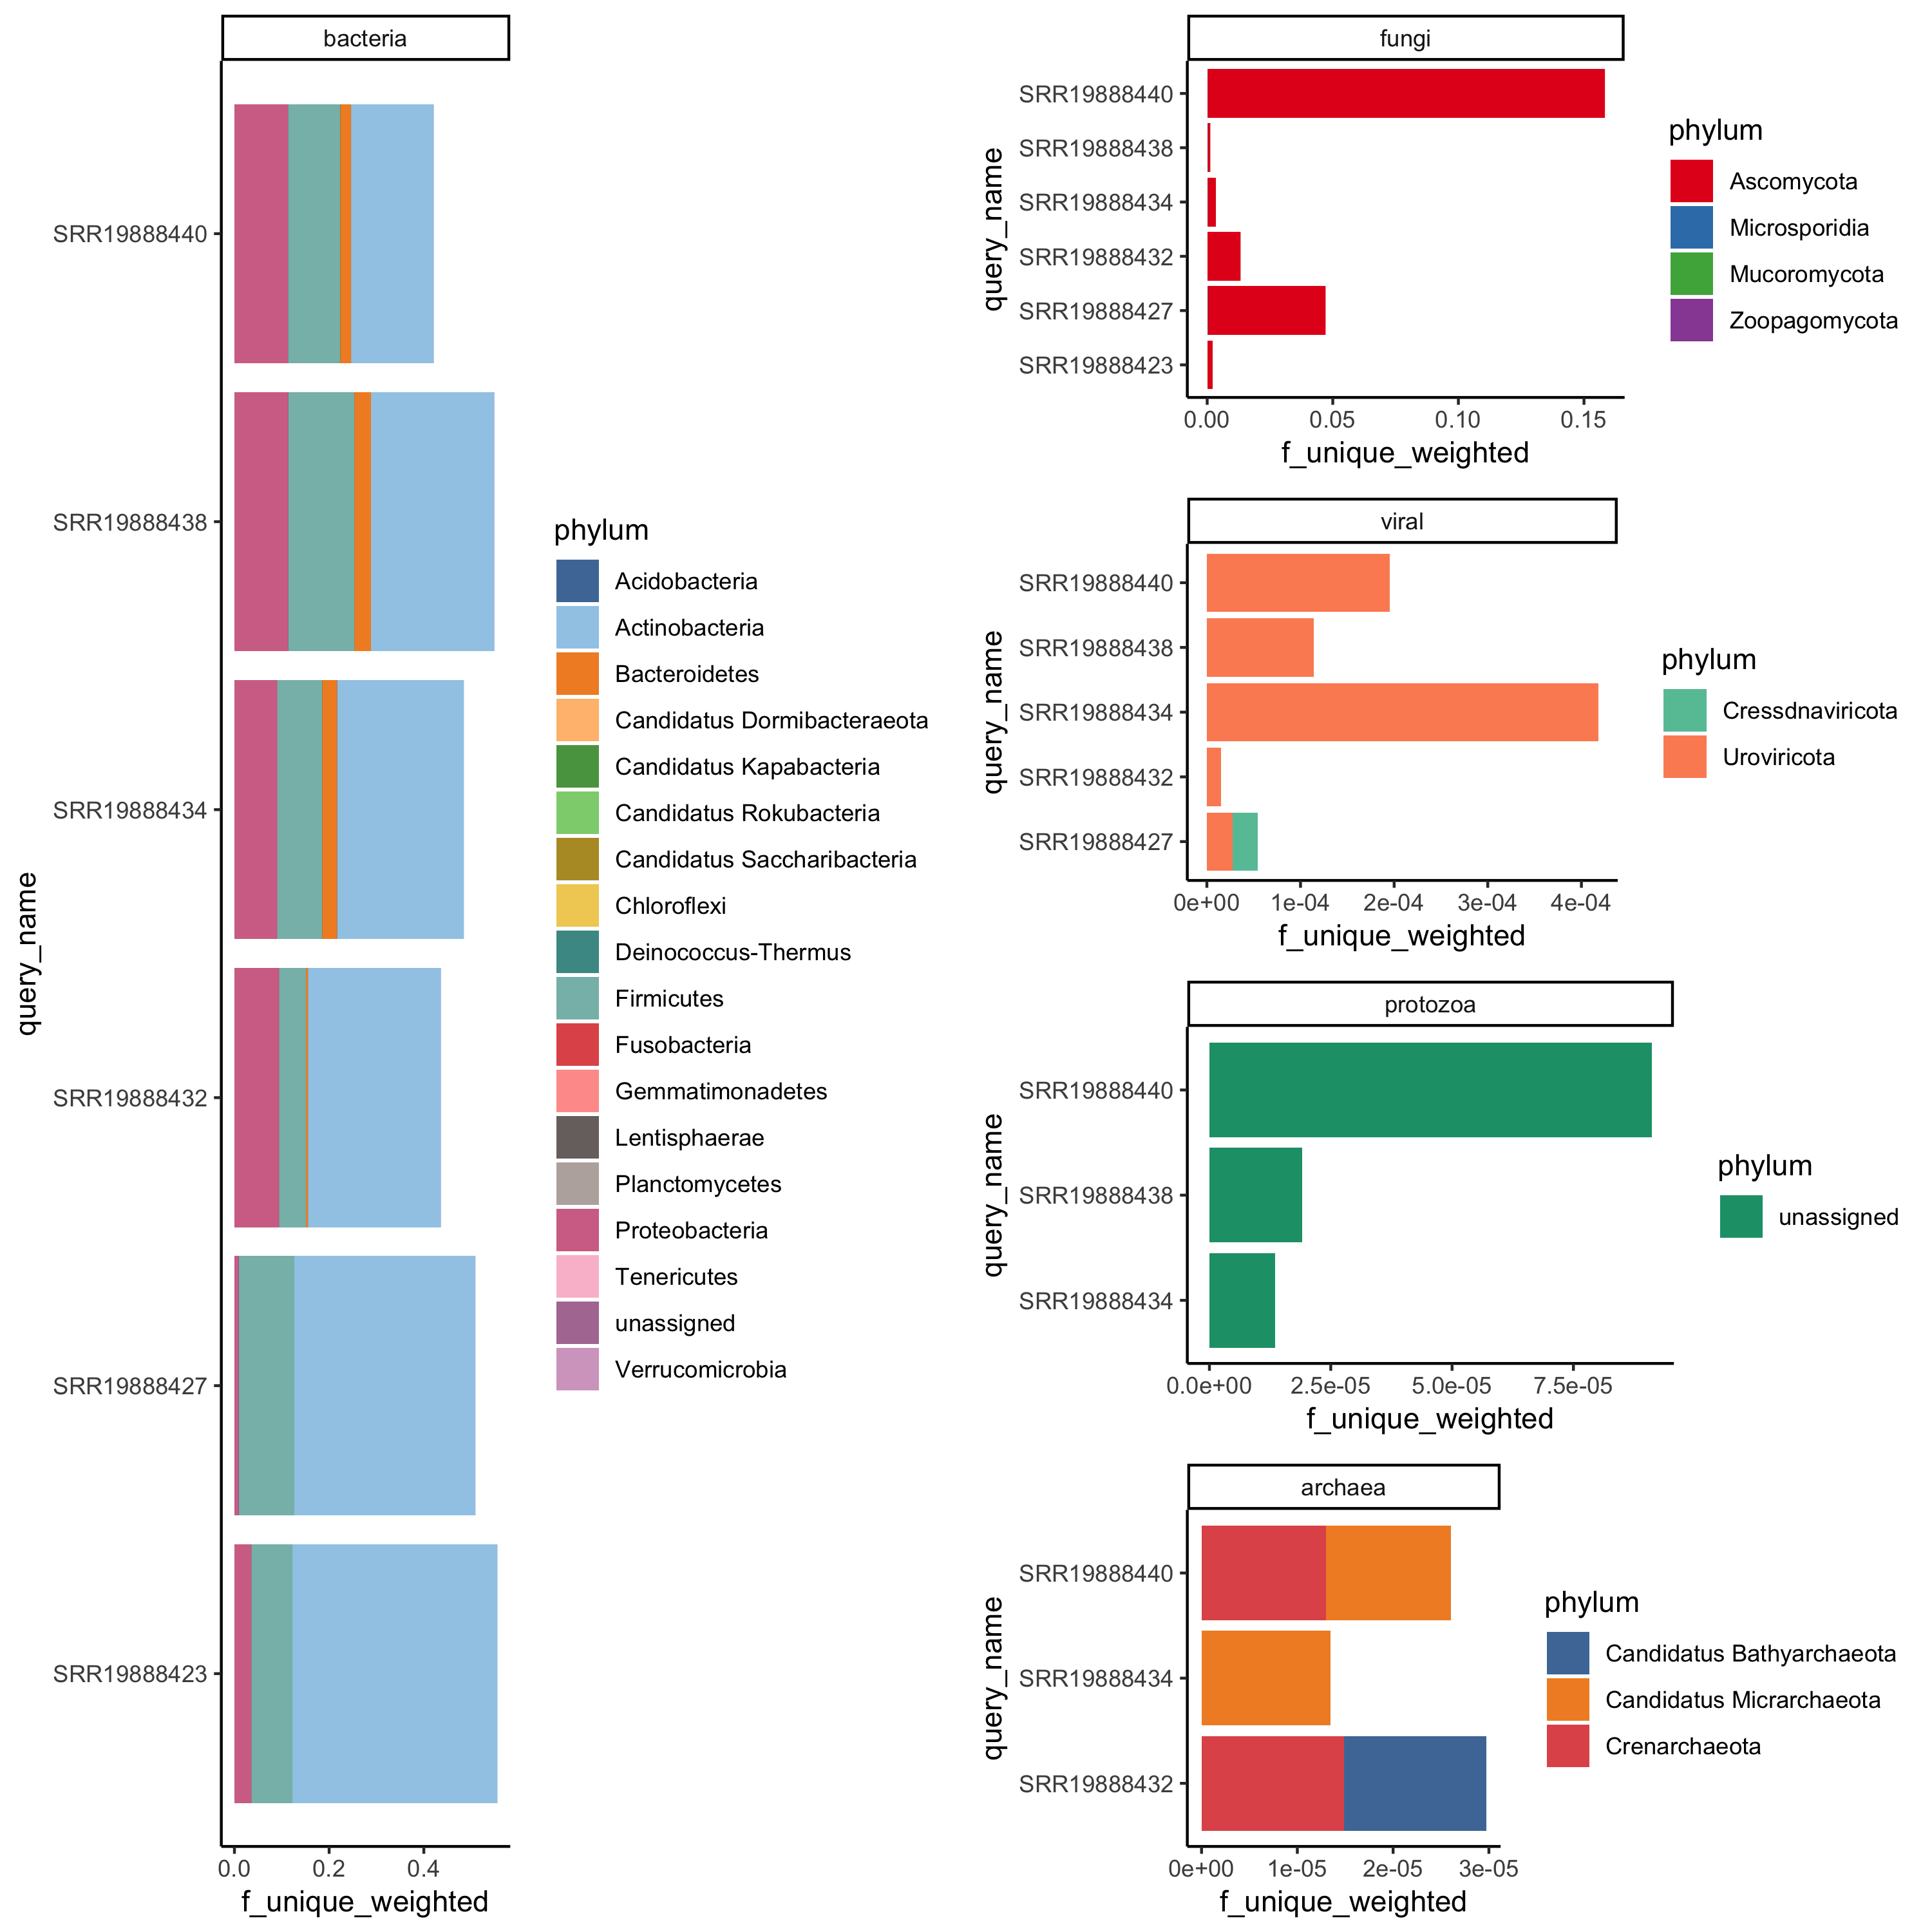

In [13]:
ggarrange(bacteria_plot, 
          ggarrange(fungi_plot, viral_plot, protozoa_plot, archaea_plot, nrow =4, ncol = 1), ncol = 2)

## Upset plot of shared lineages observed between samples

The below upset plot shows the number of shared lineages between samples. 
These are full lineages, which may be represented up to the strain level.

In [35]:
# re-read in taxonomy results in list format instead of parsing from the above data
files <- Sys.glob("outputs/sourmash_taxonomy/*k31*csv") # list files in the taxonomy folder that contain k31 and end with .csv
sourmash_taxonomy_upset_list <- list()
for(i in 1:length(files)){
    taxonomy <- read_csv(files[i], show_col_types = F) # read in the sourmash taxonomy results
    sample_name <- unique(taxonomy$query_name)       # record the signature name which is currently stored as the column name
    sourmash_taxonomy_upset_list[[i]] <- taxonomy$lineage      # record the lineage names in a list
    names(sourmash_taxonomy_upset_list)[i] <- sample_name  # set the name of the list index to the signature name
}

In [64]:
# re-format the list into format needed to make upset plot
upset_df <- UpSetR::fromList(sourmash_taxonomy_upset_list)

In [65]:
# re-derive appropriate domain labels using lineages

# first, make a data frame that has lineage:database mapping
lineage_to_db <- sourmash_taxonomy %>%
  select(database, lineage) %>%
  distinct()

upset_df <- upset_df %>%
  mutate(lineage = unique(unlist(sourmash_taxonomy_upset_list))) %>%
  left_join(lineage_to_db, by = "lineage")

head(upset_df)

,SRR19888423,SRR19888427,SRR19888432,SRR19888434,SRR19888438,SRR19888440,lineage,database
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,1,1,1,1,1,1,Bacteria;Actinobacteria;Actinomycetia;Micrococcales;Dermabacteraceae;Brachybacterium;Brachybacterium alimentarium,bacteria
2,1,1,1,1,1,1,Bacteria;Actinobacteria;Actinomycetia;Micrococcales;Brevibacteriaceae;Brevibacterium;Brevibacterium aurantiacum,bacteria
3,1,1,1,1,1,1,Bacteria;Actinobacteria;Actinomycetia;Micrococcales;Brevibacteriaceae;Brevibacterium;Brevibacterium sp. S111,bacteria
4,1,1,1,1,1,1,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Corynebacterium casei,bacteria
5,1,1,1,1,1,1,Bacteria;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus equorum;Staphylococcus equorum subsp. equorum Mu2,bacteria
6,1,1,1,1,1,1,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Candidatus Corynebacterium faecigallinarum,bacteria


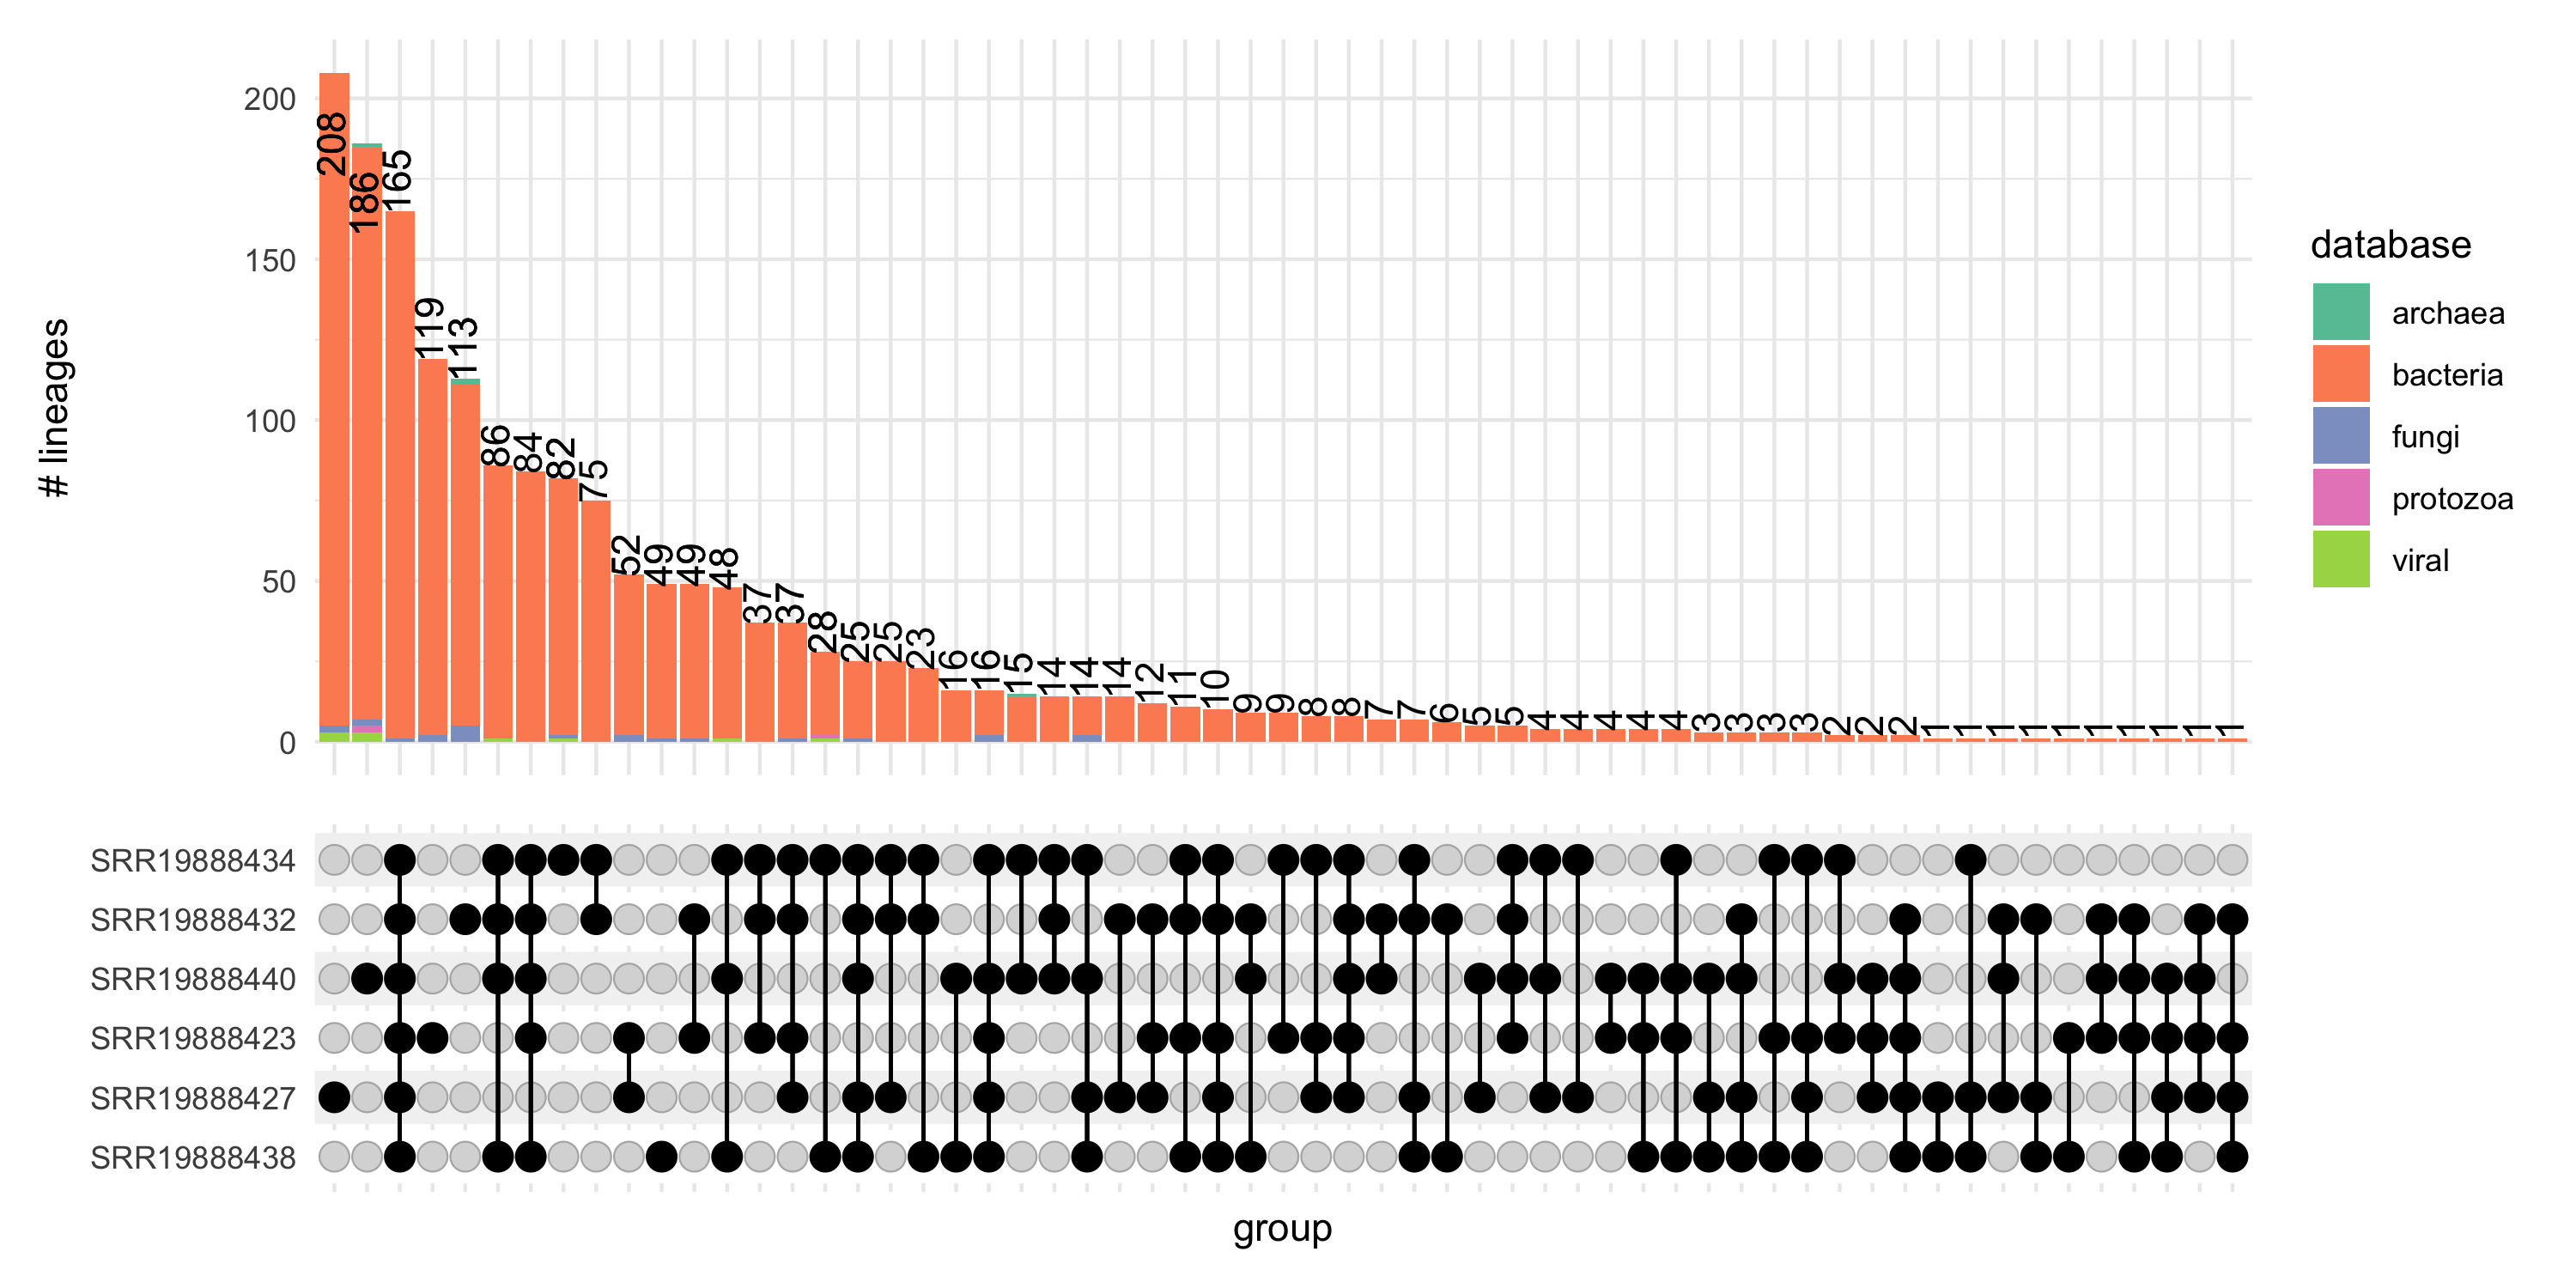

In [62]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

# uncomment code to get an upset plot not colored by domain
# plot the upset plot
# upset(upset_df, intersect = names(sourmash_taxonomy_list), set_sizes = F, 
#      base_annotations=list(
#          '# lineages'=intersection_size(text=list(vjust=0.4, hjust=.05, angle=90), 
#                                                          text_colors=c(on_background='black', on_bar='black'),
#                                                          mapping=aes(fill='bars_color')) + 
#           scale_fill_manual(values=c('bars_color'='lightgrey'), guide='none'))
#     )

# plot the upset plot
upset(upset_df, intersect = names(sourmash_taxonomy_list), set_sizes = F, 
      base_annotations=list(
          '# lineages'=intersection_size(text=list(vjust=0.4, hjust=.05, angle=90), 
                                                          text_colors=c(on_background='black', on_bar='black'),
                                                          mapping=aes(fill=database)) +
          scale_fill_brewer(palette = "Set2"))
     )

In [63]:
upset_overlap_groups(sourmash_taxonomy_upset_list)

$SRR19888427
656 659 660 664 666 667 668 669 670 675 677 678 679 680 681 682 685 690 694 695 
656 659 660 664 666 667 668 669 670 675 677 678 679 680 681 682 685 690 694 695 
696 698 701 703 704 706 708 709 710 711 712 713 714 715 716 718 720 721 722 723 
696 698 701 703 704 706 708 709 710 711 712 713 714 715 716 718 720 721 722 723 
724 725 726 728 729 730 731 732 733 734 735 736 737 738 741 742 743 744 747 748 
724 725 726 728 729 730 731 732 733 734 735 736 737 738 741 742 743 744 747 748 
749 751 752 756 757 758 759 762 763 764 767 768 769 770 772 773 775 776 777 778 
749 751 752 756 757 758 759 762 763 764 767 768 769 770 772 773 775 776 777 778 
779 780 781 782 783 784 785 786 788 790 791 792 797 798 799 802 803 804 805 806 
779 780 781 782 783 784 785 786 788 790 791 792 797 798 799 802 803 804 805 806 
807 808 809 810 811 812 813 816 817 818 819 821 822 826 827 828 829 832 833 835 
807 808 809 810 811 812 813 816 817 818 819 821 822 826 827 828 829 832 833 835 
836 838 839 840 841 842 844 846 847 848 851 852 855 857 858 861 863 865 867 868 
836 838 839 840 841 842 844 846 847 848 851 852 855 857 858 861 863 865 867 868 
870 873 876 879 880 881 882 883 884 885 886 887 888 889 890 891 893 894 895 896 
870 873 876 879 880 881 882 883 884 885 886 887 888 889 890 891 893 894 895 896 
898 899 900 901 902 903 904 905 906 907 908 910 916 918 919 920 921 923 925 926 
898 899 900 901 902 903 904 905 906 907 908 910 916 918 919 920 921 923 925 926 
928 931 932 933 934 935 937 939 940 941 943 946 947 948 949 950 951 953 954 957 
928 931 932 933 934 935 937 939 940 941 943 946 947 948 949 950 951 953 954 957 
958 960 961 962 963 964 965 968 
958 960 961 962 963 964 965 968 
attr(,"groups")
SRR19888423 SRR19888427 SRR19888432 SRR19888434 SRR19888438 SRR19888440 
      FALSE        TRUE       FALSE       FALSE       FALSE       FALSE 

$SRR19888440
1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 
1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 
1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 
1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 
1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 
1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 
1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603 
1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603 
1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 
1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 
1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 
1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 
1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 
1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 
1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 
1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 
1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 
1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 
1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 
1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 
1700 1701 1702 1703 1704 1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 
1700 1701 1702 1703 1704 1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 
1716 1717 1718 1719 1720 1721 1722 1723 1724 1725 
1716 1717 1718 1719 1720 1721 1722 1723 1724 1725 
attr(,"groups")
SRR19888423 SRR19888427 SRR19888432 SRR19888434 SRR19888438 SRR19888440 
      FALSE       FALSE       FALSE       FALSE       FALSE        TRUE 

$SRR19888423_SRR19888427_SRR19888432_SRR19888434_SRR19888438_SRR19888440
  1  